**PREPROCESSING SHANGHAITECH PART-A**

Import Libraries

In [12]:
import os
import cv2
import numpy as np
import scipy.io as sio
from scipy.ndimage import gaussian_filter
import torch
from tqdm import tqdm
import matplotlib.pyplot as plt

Define Paths

In [13]:
root = r"C:\Users\sneha\.cache\kagglehub\datasets\tthien\shanghaitech\versions\1\ShanghaiTech"

partA_img_dir = os.path.join(root, "part_A", "train_data", "images")
partA_mat_dir = os.path.join(root, "part_A", "train_data", "ground-truth")

save_dir = r"C:\Users\sneha\Crowd_Preprocessed"
os.makedirs(save_dir, exist_ok=True)


Utility Function: Load Image

In [14]:
def load_image(path):
    """
    Loads an image using OpenCV (BGR), converts to RGB.
    Returns: RGB image (H,W,3)
    """
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img


Utility Function: Load .mat Ground Truth

In [21]:
def load_mat_points(mat_path):
    """
    Loads the head annotation points from the ShanghaiTech .mat format.

    Structure:
    image_info -> 0 -> 0 -> 0 -> 0 -> points
    """
    mat = sio.loadmat(mat_path)
    points = mat["image_info"][0][0][0][0][0]
    return points.astype(np.float32)


Utility Function: Resize Image + Scale Points

In [15]:
def resize_and_scale(img, points, new_w=512, new_h=512):
    """
    Resizes the image and scales the point coordinates accordingly.
    """
    h0, w0 = img.shape[:2]

    img_resized = cv2.resize(img, (new_w, new_h))
    h1, w1 = img_resized.shape[:2]

    scale_w = w1 / w0
    scale_h = h1 / h0

    scaled_points = []
    for x, y in points:
        scaled_points.append([x * scale_w, y * scale_h])

    return img_resized, np.array(scaled_points)


Normal Density Map Function

In [16]:
def generate_density(img_shape, points, sigma=4):
    """
    Creates a smooth Gaussian density map using fixed sigma.
    This is the standard approach used for Part_A and Part_B.

    img_shape: (H, W)
    points: Nx2 array of (x,y)
    sigma: Gaussian blur strength
    """
    H, W = img_shape
    density = np.zeros((H, W), dtype=np.float32)

    for x, y in points:
        x = int(min(W - 1, max(0, x)))
        y = int(min(H - 1, max(0, y)))
        density[y, x] += 1

    density = gaussian_filter(density, sigma, mode="constant")
    return density


Convert to Tensor

In [ ]:
def to_tensor(img_resized, density):
    """
    Converts resized RGB image and density map to PyTorch tensors.
    Image: CHW format normalized to [0,1]
    Density: HW float tensor
    """
    img_t = torch.tensor(img_resized / 255.0, dtype=torch.float32).permute(2, 0, 1)
    den_t = torch.tensor(density, dtype=torch.float32)
    return img_t, den_t

Save Output

In [18]:
def save_sample(save_dir, filename, img_t, den_t):
    """
    Saves tensors as .pt files.
    Example filename: IMG_1.pt
    """
    save_path = os.path.join(save_dir, filename.replace(".jpg", ".pt"))
    torch.save({"image": img_t, "density": den_t}, save_path)


PROCESS THE ENTIRE PART-A TRAIN FOLDER

In [19]:
img_files = sorted([f for f in os.listdir(partA_img_dir) if f.endswith(".jpg")])

print("Total images:", len(img_files))


Total images: 300


In [24]:
for img_name in tqdm(img_files):
    
    # full paths
    img_path = os.path.join(partA_img_dir, img_name)
    mat_path = os.path.join(partA_mat_dir, "GT_" + img_name.replace(".jpg", ".mat"))

    # load
    img = load_image(img_path)
    points = load_mat_points(mat_path)

    # resize + scale
    img_resized, scaled_points = resize_and_scale(img, points)

    # density map
    density = generate_density(img_resized.shape[:2], scaled_points, sigma=2)

    # to tensor
    img_t, den_t = to_tensor(img_resized, density)

    # save
    save_sample(save_dir, img_name, img_t, den_t)


100%|██████████| 300/300 [00:13<00:00, 22.54it/s]


Listing Tensors 

In [35]:
img_tensor, density_tensor = to_tensor(img_resized, density)
print("Image Tensor Shape:", img_tensor.shape)
print("Density Tensor Shape:", density_tensor.shape)

print("\nSample Scaled Points Tensor:")
print(scaled_points[:10])   # print first 10 points


Image Tensor Shape: torch.Size([3, 512, 512])
Density Tensor Shape: torch.Size([512, 512])

Sample Scaled Points Tensor:
[[  9.65946  431.1996  ]
 [ 48.53259  407.59973 ]
 [ 21.423697 361.9226  ]
 [ 38.814304 355.07104 ]
 [ 14.262857 335.27762 ]
 [ 22.958162 317.76807 ]
 [ 15.285834 292.64563 ]
 [ 39.325794 291.12308 ]
 [ 16.308811 237.07184 ]
 [ 26.027092 231.74284 ]]


Visualize Random Sample

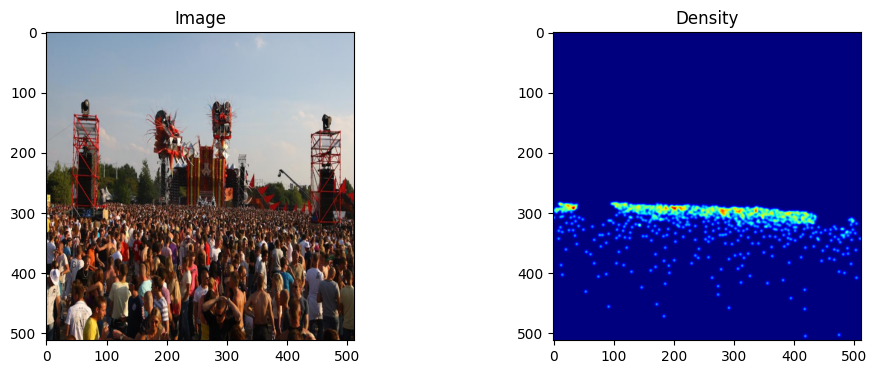

In [34]:
sample = torch.load(os.path.join(save_dir, img_files[100].replace(".jpg", ".pt")))
img_t = sample["image"]
den_t = sample["density"]

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.imshow(img_t.permute(1,2,0))
plt.title("Image")

plt.subplot(1,2,2)
plt.imshow(den_t, cmap="jet")
plt.title("Density")
plt.show()
